# Lab #3 Object Tracking with GlounCV

--------

In this lab, we will run an object tracking example on frames extracted from videos using the GluonCV's SiamRPN model.

SiamRPN model is a widely adopted single object tracking method that consists of a Siamese subnetwork for feature extraction, and a region proposal subnetwork including the classification branch and regression branch for prediction. In the inference phase, the proposed framework is formulated as a local one-shot detection task. We can pre-compute the template branch of the Siamese subnetwork and formulate the correlation layers as trivial convolution layers to perform online tracking.

GluonCV's SiamRPN is very stable for know objects. It can track the object even when it moves at high speed and is partially occluded.

For more information on this tracking network you can check: https://cv.gluon.ai/build/examples_tracking/index.html


The process that will be carried out is shown in the following diagram:

<img src="../images/Lab1_2_1.jpeg" alt="Lab1_2_1" width="800"/>

## Setup

Uncomment and run this cell only the first time.

In [23]:
!pip install opencv-python
!pip install gluoncv

#### Libraries

In [24]:
import sagemaker
from sagemaker.mxnet import MXNet
import mxnet as mx
import gluoncv as gcv
from gluoncv import model_zoo, data, utils
import matplotlib.pyplot as plt
import glob, math, logging
import numpy as np
import json, cv2, os
import boto3
import ast, uuid, time

#### Variables

In [25]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = 'rodzanto2021ml' #TODO: Update this value
#bucket = sagemaker_session.default_bucket()
task = 'gluoncv-frsign'
images_prefix = 'train/frsign/data/images'
label_prefix = 'train/frsign/data'
classes = [
    'Chassis A (3 feux verticaux)',
    'Chassis C (5 feux verticaux)',
    'Chassis F (6 & 1 feux en L inverse)',
    'Chassis H (6 & 3 feux en S)',
    'Chassis ID2 (2 feux horizontaux)',
    'Chassis ID3 (3 feux horizontaux)',
    'Chassis R (6 feux dans un disque)'
]
inf_prefix = 'train/frsign/data/validation'

print('Execution_role:',role)
print('S3_bucket:',bucket)
print('Ground-truth_labeling task:',task)
print('S3_images_prefix:',images_prefix)
print('S3_label_prefix:',label_prefix)
print('Labeling_classes:',classes)
print('S3_inference_prefix:',inf_prefix)

Execution_role: arn:aws:iam::759352851214:role/service-role/mod-f37b0e76044c4c67-SageMakerExecutionRole-1COXCFW253JLU
S3_bucket: rodzanto2021ml
Ground-truth_labeling task: gluoncv-frsign
S3_images_prefix: train/frsign/data/images
S3_label_prefix: train/frsign/data
Labeling_classes: ['Chassis A (3 feux verticaux)', 'Chassis C (5 feux verticaux)', 'Chassis F (6 & 1 feux en L inverse)', 'Chassis H (6 & 3 feux en S)', 'Chassis ID2 (2 feux horizontaux)', 'Chassis ID3 (3 feux horizontaux)', 'Chassis R (6 feux dans un disque)']
S3_inference_prefix: train/frsign/data/validation


### Start

We need two things to start the tracking demo: a video and its first frame object coordinates. The coordinates show the region of interest where to track, and in the format of (min_x, min_y, width, height).

In this case, we specify a sample video and set the region of interest in the first frame, in this example: the location of the railway traffic light.

In [26]:
video_path = '../sample_media/atocha_cut.mp4'
#Bounding box of the object to detect according to the first frame of your own video:
gt_min_x = 982
gt_min_y = 283
gt_w = 12
gt_h = 26

if not os.path.exists('predictions'):
    os.makedirs('predictions')

Then, you can simply use the GluonCV provided script to obtain the object tracking result.

In [27]:
!python gluoncv/demo.py --video-path $video_path --gt-bbox $gt_min_x $gt_min_y $gt_w $gt_h

../sample_media/atocha_cut.mp4
Figure(640x480)
[2022-01-20 16:33:22.870 ip-172-16-54-19:11202 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-20 16:33:22.891 ip-172-16-54-19:11202 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


The object tracking result will be a set of images with a bounding box of the detected railway traffic light. This result will be used to create a video called `atocha_cut_animation.mp4`

In [28]:
import os

files = [f for f in os.listdir('./predictions') if f[-3:] == 'jpg']
files.sort()

def make_video(images, outvid, outimg=None, fps=25, size=None,
               is_color=True, format="XVID"):
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        image = 'predictions/{}'.format(image)
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

make_video(files, 'atocha_cut_animation.mp4')

<VideoWriter 0x7f0e36d11670>

Once the video is saved, we play it to reproduce the result

In [29]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('./atocha_cut_animation.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

`- Note: If the video is not playing in the notebook, you can download it from the "File Browser" in the left panel and play it locally in your PC. -`

Here is a sample image from the resulting tracking animation. Look at the yellow bounding box following the ball.

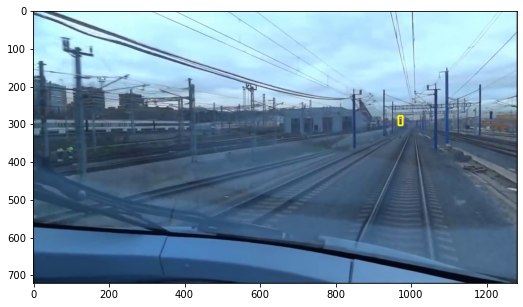

In [30]:
image = plt.imread('predictions/{}'.format(files[10]))
fig = plt.figure(figsize = (10,5))
plt.imshow(image)
plt.show()

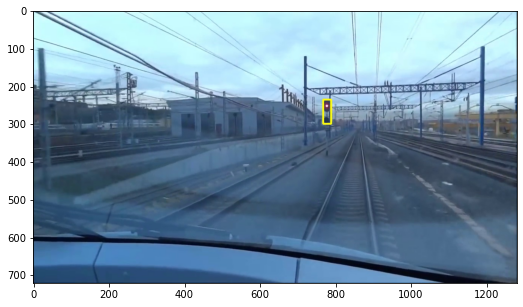

In [31]:
image = plt.imread('predictions/{}'.format(files[100]))
fig = plt.figure(figsize = (10,5))
plt.imshow(image)
plt.show()

*Note: You could also adapt this example for performing transfer-learning with your own dataset for increasing the accuracy of the tracking, based on this example: https://cv.gluon.ai/build/examples_tracking/index.html*